<a href="https://colab.research.google.com/github/Juanmagithb/bendigo/blob/main/Desafio_CrossValidation_%2BJuan_%2BAlegre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

**Contexto comercial**

Gran parte de la actividad economica en Bendigo se debe la extranccion de minerales.
Es por esto que el clima es un factor crítico que puede afectar directamente la producción y los costos de la operación minera. Las condiciones climáticas, como las lluvias, la nieve, el viento, la temperatura y la humedad, pueden afectar la seguridad de los trabajadores, la calidad del mineral extraído y la eficiencia de los procesos de producción.

Un sistema predictivo del clima en una economía minera como la Bendigo tendría un contexto comercial muy importante, ya que podría proporcionar información precisa y oportuna sobre las condiciones climáticas futuras, lo que permitiría a las empresas mineras tomar decisiones informadas sobre sus operaciones. Algunas aplicaciones comerciales de un sistema predictivo del clima en una economía minera podrían incluir:


*   **Planificación de operaciones mineras:** Un sistema predictivo del clima podría ayudar a las empresas mineras a planificar sus operaciones con anticipación, lo que les permitiría ajustar su producción y sus procesos para adaptarse a las condiciones climáticas previstas. Por ejemplo, si se pronostica una tormenta de nieve, la empresa podría reducir su producción para evitar que se acumule nieve en los caminos y reducir el riesgo de accidentes.

*   **Gestión de riesgos:** Las condiciones climáticas extremas pueden aumentar los riesgos para los trabajadores y la infraestructura de la mina. Un sistema predictivo del clima podría ayudar a las empresas a identificar y gestionar estos riesgos, permitiendo la evacuación de los trabajadores en caso de una tormenta o la preparación de equipos para soportar condiciones climáticas adversas.

*   **Optimización de costos:** Al tener información precisa sobre las condiciones climáticas futuras, las empresas mineras podrían optimizar sus costos de producción al planificar mejor la programación de sus operaciones y minimizar los costos asociados con el clima, como el mantenimiento de carreteras y el consumo de energía.

**Problema comercial**

Debemos dar respuestas a la siguientes preguntas:

*   ¿En que epoca del año es probable que se interrupan las actividades por lluvia?

*   ¿En que epoca del año se deben tomar mayores precauciones frente a las nevadas?

*   ¿Las temperaturas permiten que las actividades se realicen de forma optima?

**Contexto Analitico**

Variables de interes:

*   Moth: Mes
*   Year : Año
*   MinTemp : Temperatura minima en °C
*   MaxTemp : Temperatura maxima en °C
*   Rainfall : Lluvia en mm
*   Humidity9am : % de humedad a las 9am
*   Humidity3pm : % de humedad a las 3pm
*   Pressure9am : Presion atmosferica a las 9am en hPa
*   Pressure3pm : Presion atmosferica a las 3am en hPa
*   Temp9am : Temperatura a las 9am en °C
*   Temp3pm : Temperatura a las 3pm en °C
*   RainToday : Se verifica lluvia en el dia
*   RainTomorrow : Se verifica lluvia el dia siguiente

# Setup

**Importacion de librerias**

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import requests
import json

**Conexion con google drive**

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bendigo_weather = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/Bendigo_weather.xlsx')

# EDA + Data Wrangling

**Control de duplicados**

In [ ]:
bendigo_weather["Date"].duplicated().sum()

0

Se verifica que no hay registros duplicados


---


**Feature selection #1**

In [ ]:
bendigo_weather.drop(['Location' , 'Evaporation', 'Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Cloud9am','Cloud3pm'],axis = 1, inplace = True)

Dejamos unicamente las variables necesarias para el Storytelling

---

**Analisis de datos nulos**

In [ ]:
bendigo_weather.isnull().sum()

Date             0
Day              0
Moth             0
Year             0
MinTemp          2
MaxTemp          5
Rainfall         6
Humidity9am      7
Humidity3pm      2
Pressure9am     15
Pressure3pm     10
Temp9am          3
Temp3pm          2
RainToday        6
RainTomorrow     6
dtype: int64

Por fortuna tenemos muy pocos casos nulos que no suponen una cantidad representativa respecto al df, es por esto que se decide eliminar los mismos para agilizar el proceso y evitar posibles outliers.

In [ ]:
bendigo_weather.dropna(subset=[ 'MinTemp','MaxTemp','Rainfall','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am', 'Temp3pm','RainToday','RainTomorrow' ], inplace = True)

Se perdieron el proceso de depuracion 31 filas de datos, que representan un  %1 del df original.



---

**Analisis circustancial**

En el caso de el dato **Rainfall** que representa la cantidad de lluvia registrada de forma diaria, no tiene sentido que este dato tenga un valor superior a 0 si el valor de **RainToday** es igual a "No".
Procedemos a depurar quellos casos que no cumplan con las condiciones antes mencionadas.

In [ ]:
rain_today_no = bendigo_weather[bendigo_weather.RainToday == "No"]
rain_today_no.Rainfall.unique()

array([0. , 0.2, 0.8, 0.4, 1. , 0.6])

En los todos los casos no se supero el 1mm de precipitacion registrada.

In [ ]:
rain_today_no = rain_today_no[rain_today_no.Rainfall > 0]
rain_today_no

,Date,Day,Moth,Year,MinTemp,MaxTemp,Rainfall,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
4,2008-12-05,5,december,2008,15.1,30.3,0.2,68.0,29.0,1008.0,1005.0,21.3,29.2,No,No
5,2008-12-06,6,december,2008,9.9,27.2,0.2,60.0,29.0,1010.0,1005.6,18.0,26.2,No,No
6,2008-12-07,7,december,2008,8.0,22.0,0.2,47.0,26.0,1012.4,1010.7,13.1,20.4,No,No
10,2008-12-11,11,december,2008,8.7,28.7,0.2,43.0,13.0,1012.8,1009.7,16.8,26.3,No,No
26,2008-12-27,27,december,2008,17.5,32.1,0.2,70.0,32.0,1006.8,1002.3,21.1,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,2017-06-13,13,june,2017,1.4,15.7,0.2,99.0,61.0,1031.3,1029.1,6.2,15.2,No,No
3028,2017-06-14,14,june,2017,1.9,15.2,0.2,99.0,65.0,1030.8,1027.9,6.1,14.4,No,No
3030,2017-06-16,16,june,2017,3.3,13.8,0.2,99.0,77.0,1026.4,1024.1,5.9,13.2,No,No
3034,2017-06-20,20,june,2017,-0.3,14.1,0.2,98.0,64.0,1029.4,1026.1,4.5,13.5,No,No


Se verifican entonces 522 casos que no cumplen con la condicion, debemos entonces imputar con un 0 los valores de **Rainfall** en estos casos.

Para eso utilizamos el siguiente codigo:

In [ ]:
bendigo_weather.loc[bendigo_weather['RainToday'] == 'No', 'Rainfall'] = 0

Queda solucionada la desviacion que reportaba lluvias los dias que no se detectaron precipitaciones.


---

# Insights

## ¿En que epoca del año es probable que se interrupan las actividades de mineria por lluvia en Bendingo?

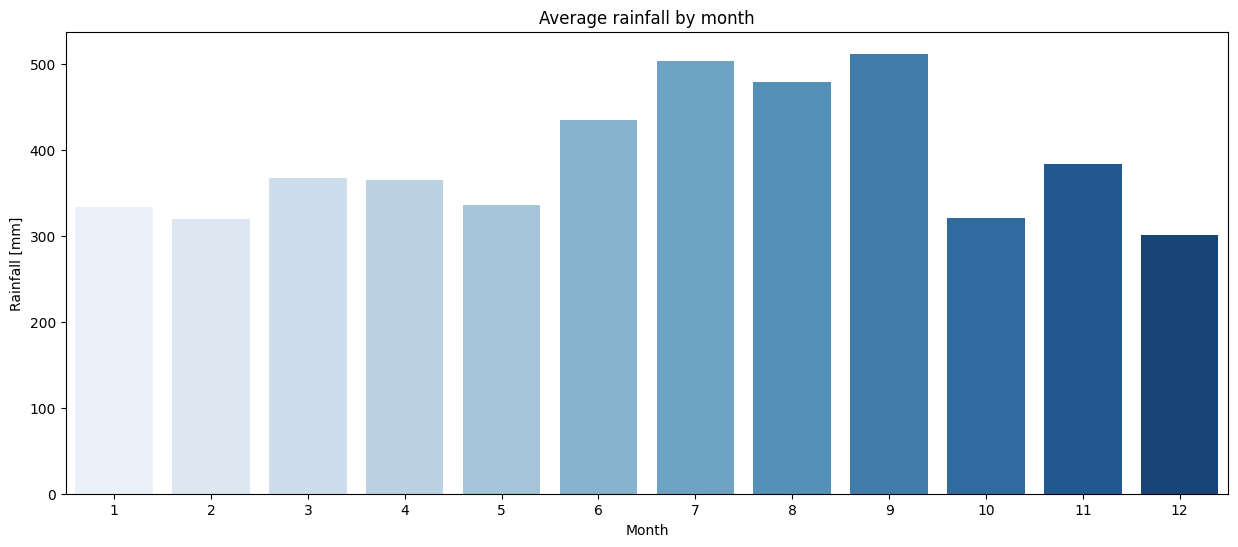

In [ ]:
bendigo_weather["month_num"] = bendigo_weather["Moth"].apply(lambda x: list(calendar.month_name).index(x.title()))

bendigo = bendigo_weather.sort_values("month_num")

rainfall_sum_by_month = bendigo.groupby('month_num')['Rainfall'].sum().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(data=rainfall_sum_by_month, x='month_num', y= "Rainfall" , palette = "Blues" )
plt.title('Average rainfall by month')
plt.xlabel('Month')
plt.ylabel('Rainfall [mm]')
plt.show()

La temporada de mayor indice de lluvias en Bendigo se da entre mayo y octubre.
Por lo que durante ese periodo se deben tomar mayores precauciones por lluvias intensas durante las actividades mineria.



---


## ¿En que epoca del año se deben tomar mayores precauciones frente a las nevadas?

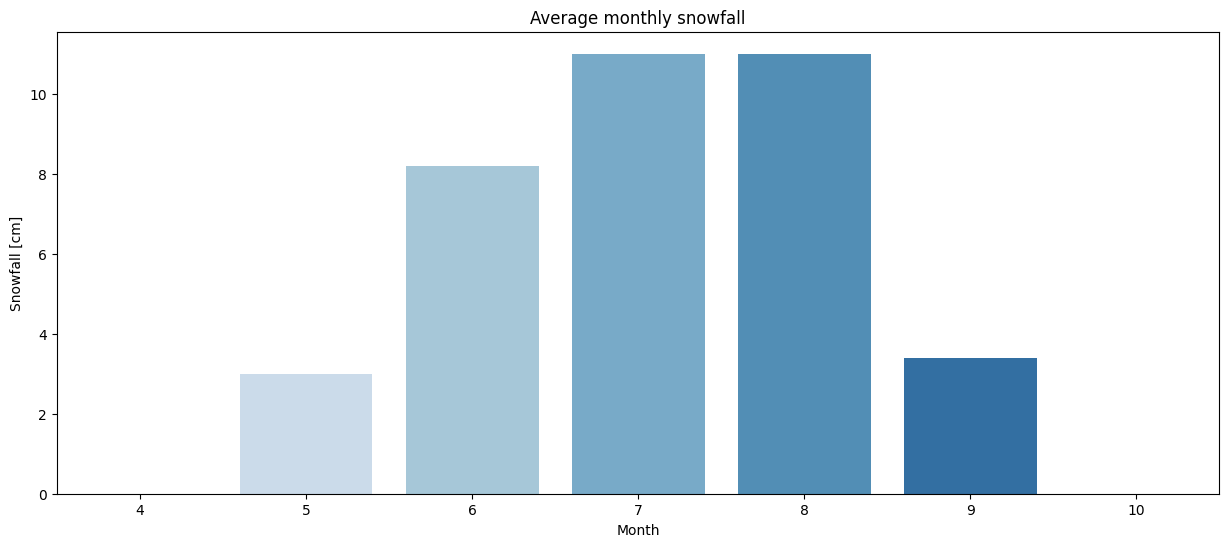

In [ ]:
bendigo_snow = bendigo[bendigo.MinTemp <0 ]

snowfall_sum_by_month = bendigo_snow.groupby('month_num')['Rainfall'].sum().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(data=snowfall_sum_by_month, x='month_num', y= "Rainfall" , palette = "Blues")
plt.title('Average monthly snowfall')
plt.xlabel('Month')
plt.ylabel('Snowfall [cm]')
plt.show()

La acumulación de nieve y el riesgo de avalanchas pueden dificultar el acceso a las áreas de trabajo y aumentar los peligros para la seguridad, por lo que durante estos periodos se deben tomar mayores precauciones por nevadas intensas durante las actividades mineria.


---


## ¿Las temperaturas permiten que las actividades se relicen de forma optima?

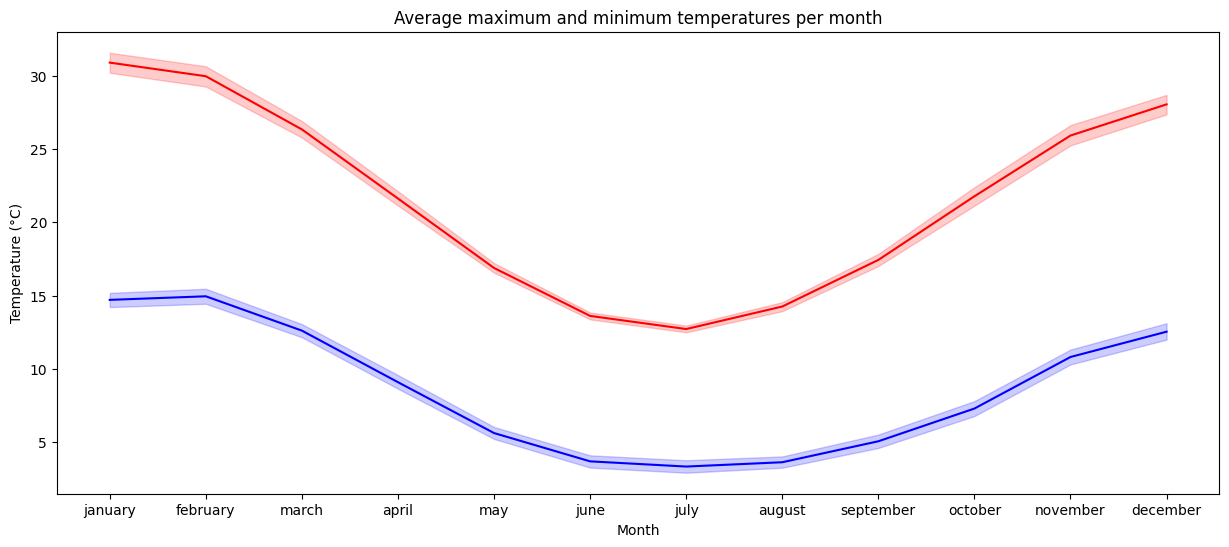

In [ ]:
temp_max = bendigo.MaxTemp
temp_min = bendigo.MinTemp

plt.figure(figsize=(15,6))
sns.lineplot(data=bendigo, x='Moth', y = temp_max , color ="red" )
sns.lineplot(data=bendigo, x='Moth', y = temp_min , color ="blue" )
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Average maximum and minimum temperatures per month')
plt.show()

La elección entre una baja o alta temperatura en una actividad minera depende de varios factores y consideraciones específicas. No hay una respuesta única o generalizada, ya que las condiciones y requerimientos pueden variar según la ubicación geográfica, el tipo de mineral, el proceso de extracción, entre otros aspectos. Aquí hay algunas consideraciones relevantes:


**Baja temperatura:**

Ventajas:

*   Puede facilitar el enfriamiento de los equipos y maquinaria utilizados en la minería.
*   Puede contribuir a un ambiente de trabajo más cómodo y seguro para los trabajadores.
*   Puede reducir el riesgo de sobrecalentamiento y fallas en los equipos.


Desventajas:

*   Puede aumentar la viscosidad de algunos fluidos utilizados en los procesos mineros.
*   Puede requerir medidas adicionales para prevenir la congelación de agua y otros líquidos.
*   Puede implicar desafíos logísticos y de infraestructura en áreas con temperaturas extremadamente bajas.


**Alta temperatura:**

Ventajas:

*   Puede ayudar a mantener la fluidez de algunos fluidos utilizados en los procesos mineros.
*   Puede permitir la operación más eficiente de ciertos equipos y maquinaria.
*   Puede facilitar la evaporación de líquidos y el secado de minerales en algunos procesos.

Desventajas:

*   Puede aumentar el estrés térmico en los trabajadores y requerir medidas adicionales de seguridad y protección.
*   Puede aumentar el consumo de energía necesario para enfriar y ventilar los espacios de trabajo.
*   Puede aumentar el riesgo de incendios y explosiones en ciertas condiciones.

# Comprobacion de Insights mediante API

## Obtencion de datos de la API

Fuente: https://openweathermap.org

Codigo de ifentificacion de la ciudad de Bendigo - > ID: 2176187

Fuente: http://bulk.openweathermap.org/sample/

In [ ]:
user_key=""

**Datos de climaticos**

Fuente: https://openweathermap.org/api/statistics-api

Debido a la imposibilidad de obtener datos históricos del clima, se utiliza la siguiente API que proporciona indicadores climáticos estadísticos basados en registros históricos obtenidos en los últimos +40 años.

De esta forma la función de la API será comparar los insight obtenidos con el dataset origen con los proporcionados por el análisis de los datos de la API.

In [ ]:
id = 2176187
url = f"https://history.openweathermap.org/data/2.5/aggregated/year?id={id}&units=metric&appid={user_key}"

response = requests.get(url)
if response.status_code == 200:
  data = response.json()

**Armado del df**

Se utilizan para armar el df los valores medios de cada parametro, salvo en el de precipitaciones que utilizamos el maximo registrado para cada dia.

In [ ]:
result_data = data['result']
df_data = []

for day_data in result_data:
    row = {
        'month': day_data['month'],
        'day': day_data['day'],
        'temperature_min': day_data['temp']['average_min'],
        'temperature_med': day_data['temp']['median'],
        'temperature_max': day_data['temp']['average_max'],
        'pressure': day_data['pressure']['median'],
        'humidity': day_data['humidity']['median'],
        'wind': day_data['wind']['median'],
        'precipitation': day_data['precipitation']['max'],
        'clouds': day_data['clouds']['median']
    }
    df_data.append(row)

# Crear el DataFrame
df = pd.DataFrame(df_data)

## Data Wrangling sobre API

**Analisis de datos nulos**

Identificar los datos nulos para cada variable objetivo para tratar los mismos

In [ ]:
df.isnull().sum()

month              0
day                0
temperature_min    0
temperature_med    0
temperature_max    0
pressure           0
humidity           0
wind               0
precipitation      0
clouds             0
dtype: int64

Por fortuna tenemos no tenemos datos nulos, esto se debe al control de los datos utilizan los creadores de la API.


---


**Control de duplicados**

La base de datos seleccionada cuenta con registros historicos de lluvia y es importante que no haya elementos de fecha duplicados

In [ ]:
df.duplicated(['month', 'day']).sum()

0

No hay registros duplicados para las fechas del df elegido, esto se debe a que la API seleccionada esta restringida a valores estadisticos para cada dia del año.


---


**Cambio de unidades**

Para mantener una coherencia en la información del df se modificaran las unidades de temperatura de grados Kelvin a grados Celsius  

In [ ]:
df['temperature_min'] = df['temperature_min'] - 273.15
df['temperature_med'] = df['temperature_med'] - 273.15
df['temperature_max'] = df['temperature_max'] - 273.15



---



**Feature selection**

Eliminar datos irrelevantes del df que no intervinen en el estudio del mismo

In [ ]:
df.drop([
    'wind',
    'clouds',
         ],axis = 1, inplace = True)

df = df.reset_index(drop=True)



---



## Insights sobre API

### ¿En que epoca del año son mas abundantes las lluvias en Bendingo?

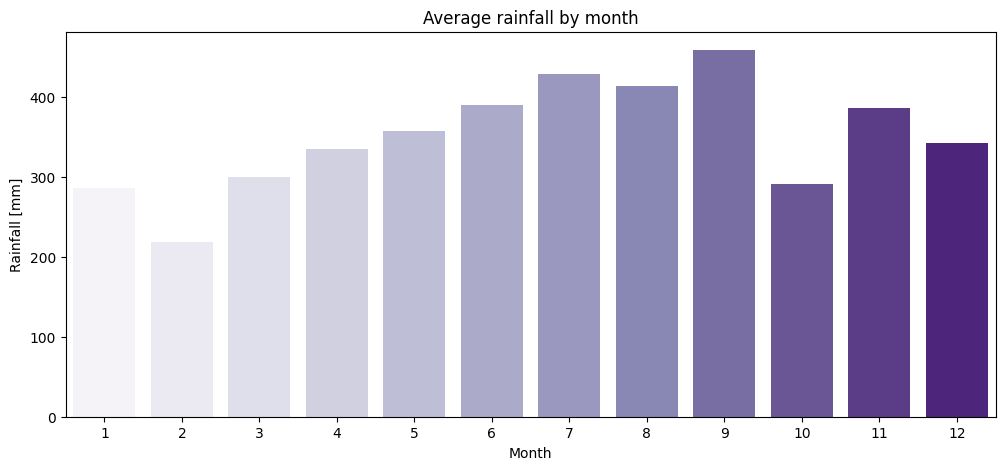

In [ ]:
rainfall_sum_by_month = df.groupby('month')['precipitation'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.barplot(data=rainfall_sum_by_month, x='month', y= "precipitation" , palette = "Purples" )
plt.title('Average rainfall by month')
plt.xlabel('Month')
plt.ylabel('Rainfall [mm]')
plt.show()

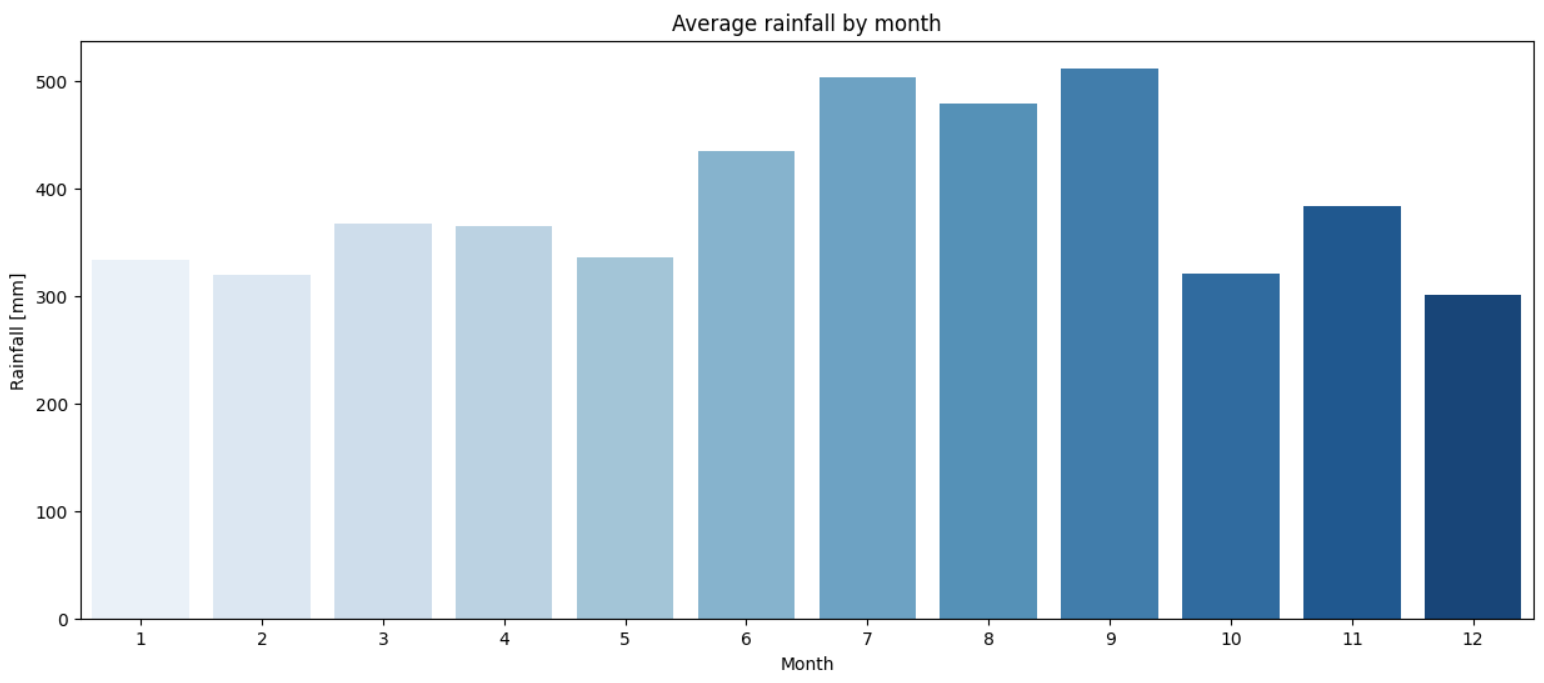

**Se verifica concordancia entre la informacion.**



---



### ¿En que epoca del año son mas abundantes las nevadas en Bendingo?

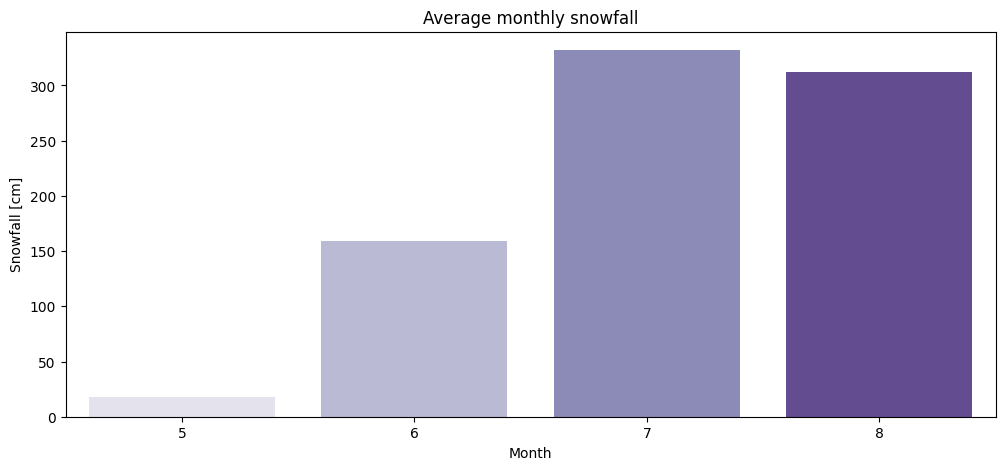

In [ ]:
bendigo_snow = df[df.temperature_min <5 ]

snowfall_sum_by_month = bendigo_snow.groupby('month')['precipitation'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=snowfall_sum_by_month, x='month', y= "precipitation" , palette = "Purples")
plt.title('Average monthly snowfall')
plt.xlabel('Month')
plt.ylabel('Snowfall [cm]')
plt.show()

Esquema obtenido mediante los datos del dataset:

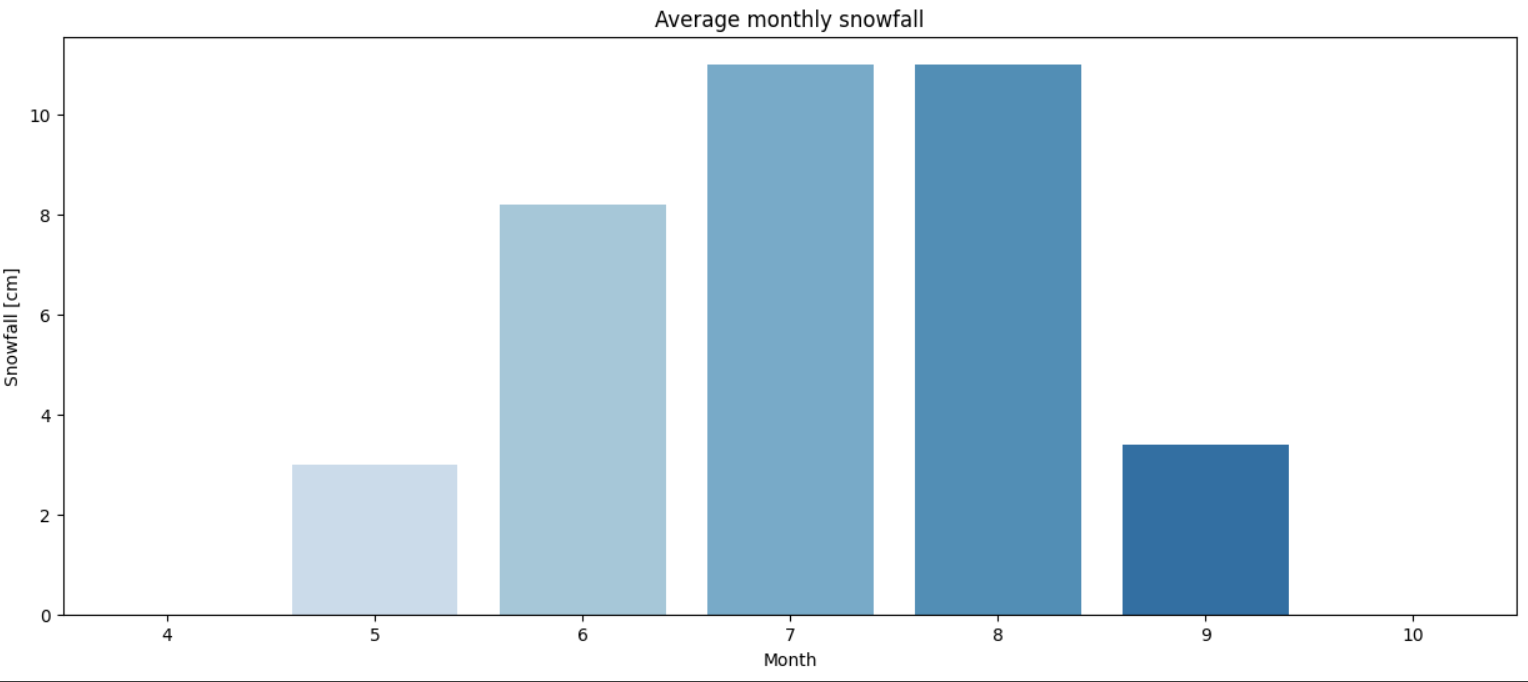

**Se verifica concordancia entre la informacion.**



---



### ¿Como fluctuan las temperaturas duante el año?

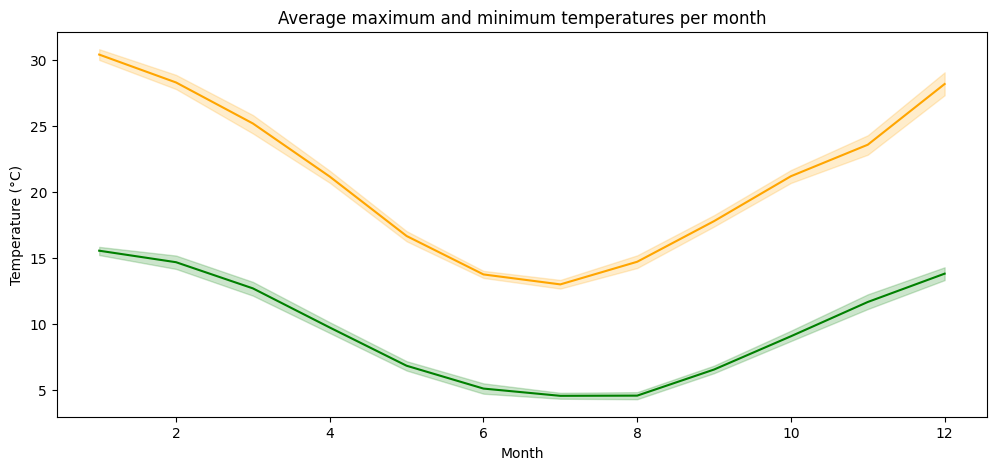

In [ ]:
temp_max = df.temperature_max
temp_min = df.temperature_min

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='month', y = temp_max , color ="orange" )
sns.lineplot(data=df, x='month', y = temp_min , color ="green" )
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Average maximum and minimum temperatures per month')
plt.show()

Esquema obtenido mediante los datos del dataset:

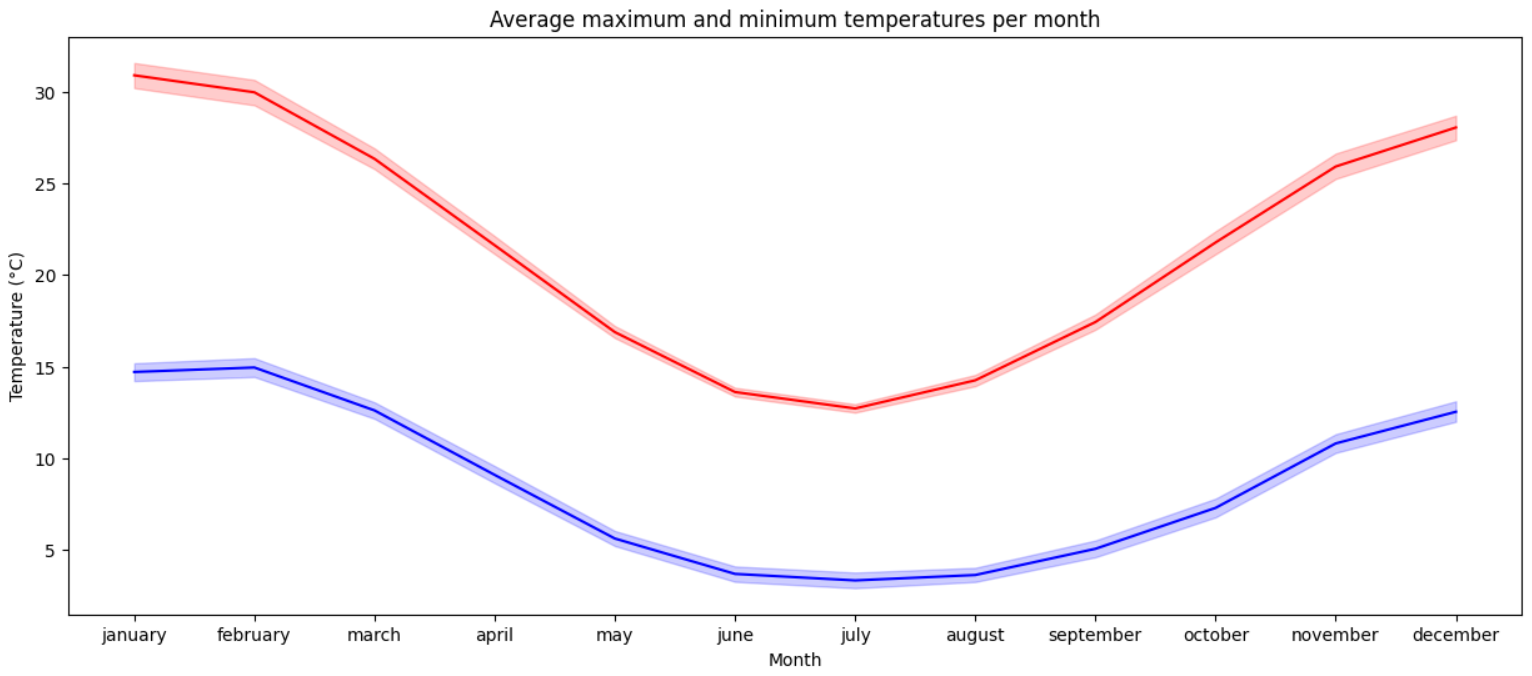

**Se verifica concordancia entre la informacion.**



---



## Conclusión

La comparación de datos de fuentes múltiples es un componente esencial en el análisis climático. Esta práctica no solo garantiza la precisión y confiabilidad de los datos utilizados, sino que también enriquece nuestra comprensión de las condiciones climáticas al ofrecer perspectivas diversas y complementarias.

Cada fuente puede emplear tecnologías y métodos de recopilación distintos. Al combinar estos enfoques diversos, es más probable que obtengamos una representación más exacta de la situación climática. La convergencia de diferentes métodos reduce la probabilidad de sesgos o errores sistemáticos.

Los visualizaciones realizadas a partir de los datos obtenidos de la API son similares a las realizadas con los datos del dataframe.

Cuando diferentes fuentes coinciden en la identificación de una misma tendencia climática o un evento particular, la probabilidad de que sea una observación válida aumenta significativamente. Esta confirmación cruzada es esencial para tomar decisiones fundamentadas.



---



# Algoritmos de clasificación

**Feature selection #2**

Eliminacion de columnas de datos no significativas para el algoritmo

In [ ]:
bendigo_weather.drop(['Date' ,'Day' ,'Moth' ,'Year','Rainfall','Temp9am', 'Temp3pm',],axis = 1, inplace = True)

**Regresión logística**

Impotacion de la biblioteca scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score , accuracy_score
from sklearn.linear_model import LogisticRegression

Dividir los datos en características (X) y variable objetivo (y)

In [ ]:
x = bendigo_weather.drop('RainToday', axis=1)
X = x.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainToday']

Dividir los datos en conjuntos de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Crear un clasificador de Regresión Logística

In [ ]:
clf = LogisticRegression()

Entrenar el clasificador

In [ ]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Realizar predicciones en el conjunto de prueba

In [ ]:
y_pred = clf.predict(X_test)

Calcular la precisión de las predicciones

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión de Regresión Logística:", accuracy)

Precisión de Regresión Logística: 0.8770764119601329


**Graficos**

Obtener los coeficientes y el intercepto del modelo

In [ ]:
coef = clf.coef_[0]
intercept = clf.intercept_

Grafico de regresión Logística para temperaturas

<ipython-input-59-f952dc72c1a2>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_test['MinTemp'], X_test['MaxTemp'],  cmap='bwr', alpha=0.6)


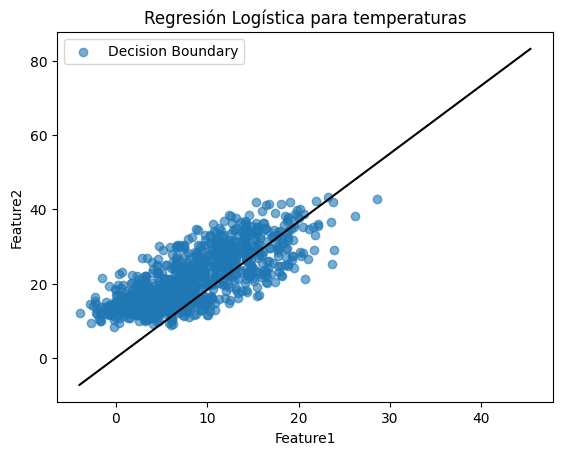

In [ ]:
plt.scatter(X_test['MinTemp'], X_test['MaxTemp'],  cmap='bwr', alpha=0.6)

# Graficar la línea de decisión
x_values = np.linspace(X['MinTemp'].min(), X['MaxTemp'].max(), 100)
y_values = -(intercept + coef[0] * x_values) / coef[1]
plt.plot(x_values, y_values, color='black')

# Personalizar el gráfico
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Regresión Logística para temperaturas')
plt.legend(['Decision Boundary'])

# Mostrar el gráfico
plt.show()



---



Grafico de regresión Logística para humedad

<ipython-input-60-4aeba23bae83>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_test['Humidity9am'], X_test['Humidity3pm'],  cmap='bwr', alpha=0.6)


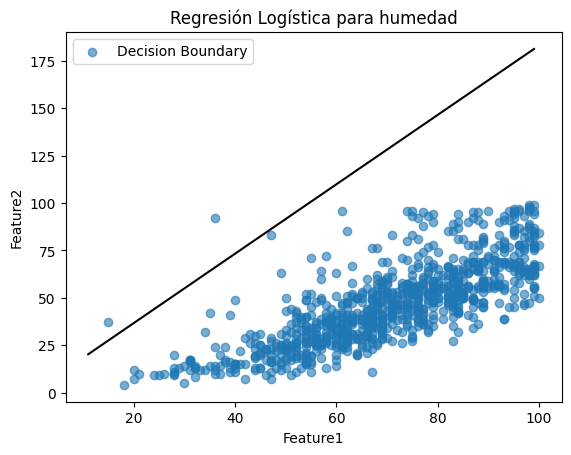

In [ ]:
plt.scatter(X_test['Humidity9am'], X_test['Humidity3pm'],  cmap='bwr', alpha=0.6)

# Graficar la línea de decisión
x_values = np.linspace(X['Humidity9am'].min(), X['Humidity3pm'].max(), 100)
y_values = -(intercept + coef[0] * x_values) / coef[1]
plt.plot(x_values, y_values, color='black')

# Personalizar el gráfico
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Regresión Logística para humedad')
plt.legend(['Decision Boundary'])

# Mostrar el gráfico
plt.show()



---



Grafico de regresión Logística para presion

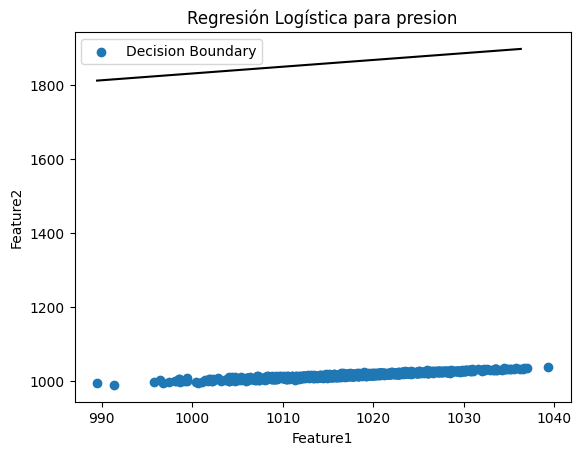

In [ ]:
plt.scatter(X_test['Pressure9am'], X_test['Pressure3pm'])

# Graficar la línea de decisión
x_values = np.linspace(X['Pressure9am'].min(), X['Pressure3pm'].max(), 100)
y_values = -(intercept + coef[0] * x_values) / coef[1]
plt.plot(x_values, y_values, color='black')

# Personalizar el gráfico
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Regresión Logística para presion')
plt.legend(['Decision Boundary'])

# Mostrar el gráfico
plt.show()



---



## Calculo del Error cuadrático medio y Coeficiente de determinación para la regresión logística

In [ ]:
x = bendigo_weather.drop('RainToday', axis=1)
X = x.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainToday']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Error cuadrático medio: 0.12292358803986711
Coeficiente de determinación (R^2): 0.1956263542251826


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Error cuadrático medio: 0.12292358803986711
Coeficiente de determinación (R^2): 0.1956263542251826


El error cuadrático medio (MSE) obtenido fue de 0.12292358803986711. Este valor indica la magnitud promedio de los errores al predecir los dias de lluvia. Un MSE más bajo indica un mejor ajuste del modelo a los datos. En este caso, el valor obtenido sugiere que el algoritmo de regresión logística tiene un buen rendimiento en la predicción de los dias de lluvia.

El coeficiente de determinación (R^2) obtenido fue de 0.1956263542251826. Este valor indica la proporción de la variabilidad en la variable objetivo (dias de lluvia) que puede explicarse por el modelo. Un valor de R^2 más cercano a 1 indica un mejor ajuste del modelo a los datos. En este caso, el valor obtenido sugiere que el modelo explica aproximadamente el 19.5% de la variabilidad en los dias de lluvia, lo cual es muy bajo.

En conclusión, el algoritmo de regresion logica aplicado a los datos seleccionados muestra un rendimiento muy bueno, con un bajo error cuadrático medio y un bajo coeficiente de determinación. Esto indica que el modelo es capaz de realizar predicciones sobre los dias de lluvia en función de las características seleccionadas con un una gran variabilidad.

# Feature Engineering

## Feature selection #3

A diferencia del feature selection #1 y #2, en esta oportunidad dejaremos una mayor cantidad de variables para deteminar mediante un análisis de correlación cuales estan en mayor o menor medida ligadas a la prediccion de precipitaciones.

Ademas se intentara predecir precipitaciones un dia posterior a la obtencion de datos. Por lo que la variable objetivo ahora sera

In [ ]:
bendigo_weather = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/Bendigo_weather.xlsx')
bendigo_weather.loc[bendigo_weather['RainToday'] == 'No', 'Rainfall'] = 0
bendigo_weather.drop(['Date','Day','Moth','Year','Location' , 'Evaporation', 'Sunshine','Cloud9am','Cloud3pm'],axis = 1, inplace = True)
bendigo_weather.dropna(subset=[ 'MinTemp','MaxTemp','WindGustDir','WindGustSpeed','Humidity9am','WindSpeed9am','Humidity3pm','WindSpeed3pm','Pressure9am','Pressure3pm','Temp9am', 'Temp3pm','WindDir9am','WindDir3pm','Rainfall' ], inplace = True)
bendigo_weather['RainTomorrow'] = bendigo_weather['RainTomorrow'].map({'Yes': 1, 'No': 0})
bendigo_weather['RainToday'] = bendigo_weather['RainToday'].map({'Yes': 1, 'No': 0})

## Análisis de Correlación

Calcular la matriz de correlación

In [ ]:
correlation_matrix = bendigo_weather.corr()

<ipython-input-170-fdfccb728d52>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bendigo_weather.corr()


Ordenar las correlaciones con la variable objetivo

In [ ]:
weather_correlation = correlation_matrix['RainTomorrow'].sort_values(ascending=False)
print(weather_correlation)

RainTomorrow     1.000000
Humidity3pm      0.466439
Humidity9am      0.287870
RainToday        0.254749
Rainfall         0.244074
WindGustSpeed    0.167033
WindSpeed3pm     0.048925
MinTemp          0.040163
WindSpeed9am    -0.010278
Temp9am         -0.097421
MaxTemp         -0.214130
Temp3pm         -0.235793
Pressure9am     -0.296489
Pressure3pm     -0.340852
Name: RainTomorrow, dtype: float64


Podemos oberservar que las variables mas significativas que estan relacionadas con las precipitaciones registradas al dia siguiente son:

*   Humidity3pm
*   Humidity9am
*   RainToday
*   Rainfall
*   WindGustSpeed
*   WindSpeed3pm
*   MinTemp

## Segunda ronda de entrenamiento de los modelos

**Preparacion de datos**

Incluiremos entonces en la nueva ronda de entrenamiento, las variables mas significativas obtenidas en el análisis de correlación


In [6]:
bendigo_weather = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/Bendigo_weather.xlsx')
bendigo_weather.loc[bendigo_weather['RainToday'] == 'No', 'Rainfall'] = 0
bendigo_weather.drop(['Location', 'Date','WindGustDir','WindSpeed9am' ,'Day' ,'Moth' ,'Year','Sunshine','Temp9am', 'Temp3pm', 'Evaporation','WindDir9am','WindDir3pm','Cloud9am','Cloud3pm','WindGustDir' ],axis = 1, inplace = True)
bendigo_weather.dropna(subset=['MaxTemp','MinTemp','Rainfall','WindGustSpeed','Humidity9am','Humidity3pm','WindSpeed3pm','RainToday','RainTomorrow','Pressure3pm','Pressure9am',], inplace = True)
bendigo_weather['RainToday'] = bendigo_weather['RainToday'].map({'Yes': 1, 'No': 0})


**Rescaleo de Datos**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning
X = bendigo_weather.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 7  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### **Regresión logística**

**Impotacion de las bibliotecas scikit-learn**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

**Calculo de precisión , error cuadrático medio y coeficiente de determinación de la regresión logística**

In [15]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión de Regresión Logística:", accuracy)
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Precisión de Regresión Logística: 0.864501679731243
Error cuadrático medio: 0.135498320268757
Coeficiente de determinación (R^2): 0.14738976738313936


### **Árbol de decisión**

**Impotacion de las bibliotecas scikit-learn**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier

**Calculo de precisión , error cuadrático medio y coeficiente de determinación  del arbol de decisión**

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión de Regresión Logística:", accuracy)
print("Error cuadrático medio:", mse)
print("Coeficiente de determinación (R^2):", r2)

Precisión de Regresión Logística: 0.8017917133258678
Error cuadrático medio: 0.19820828667413215
Coeficiente de determinación (R^2): -0.24720670391061428


## **Seleccion del modelo**

Utilizando **num_components = 7** (PCA)



*   La presicion de los nuevos modelos es del %86.45 para el modelo de regresion
logistica, mientras que la del arbol de desicion fue del %80.17.
 **En esta métrica de evaluación el modelo de regresion
logistica es superior**

*   El error cuadrático medio (MSE) obtenido fue de 0.135 para el modelo de regresion logistica, mientras que la del arbol de desicion fue del 0,198
 **En esta métrica de evaluación el arbol de desicion es superior**

*   El coeficiente de determinación (R^2) obtenido fue de 0.14 para el modelo de regresion logistica, mientras que la del arbol de desicion fue del -0.247
 **En esta métrica de evaluación el modelo de regresion
logistica es superior**


En conclusión, si bien las metricas de evaluacion son similares entre los modelos elegidos, las del modelo de regresion logistica resultan superiores a las del arbol de desicion. Si bien se reconoce que los resultados obtenidos no son los ideales, se es consciente de que se requerirán iteraciones y mejoras adicionales en el modelo en etapas posteriores. Esto incluirá la optimización de hiperparámetros, la consideración de nuevas características relevantes y otras técnicas para mejorar la precisión de las predicciones.

#Cross validation

## Preparacion de datos

**Importacion de librerias**

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import requests
import json

**Conexion con google drive**

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
bendigo_weather = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/Bendigo_weather.xlsx')

**Data Wrangling + Feature Engineering**

In [35]:
bendigo_weather = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/Bendigo_weather.xlsx')
bendigo_weather.loc[bendigo_weather['RainToday'] == 'No', 'Rainfall'] = 0
bendigo_weather.drop(['Location', 'Date','WindGustDir','WindSpeed9am' ,'Day' ,'Moth' ,'Year','Sunshine','Temp9am', 'Temp3pm', 'Evaporation','WindDir9am','WindDir3pm','Cloud9am','Cloud3pm','WindGustDir' ],axis = 1, inplace = True)
bendigo_weather.dropna(subset=['MaxTemp','MinTemp','Rainfall','WindGustSpeed','Humidity9am','Humidity3pm','WindSpeed3pm','RainToday','RainTomorrow','Pressure3pm','Pressure9am',], inplace = True)
bendigo_weather['RainToday'] = bendigo_weather['RainToday'].map({'Yes': 1, 'No': 0})

**Rescaleo de datos**

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning
X = bendigo_weather.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 7  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Metodologías de Cross validation:

*   Validación simple
*   Leave-One-Out Cross Validation (LOOCV)
*   K-Fold Cross Validation
*   Stratified K-Fold Cross Validation

### Validación simple

El procedimiento de validación simple es una forma sencilla de evaluar el rendimiento de un modelo de machine learning. Consiste en dividir tu conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto de prueba.

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score

# Crear un modelo de regresión logistica
clf = LogisticRegression()

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train_pca, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_pca)

# Calcular la precisión, el error cuadrático medio y el coeficiente de determinación
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión de Regresión Logística en validación simple:", accuracy)
print("Error cuadrático medio en validación simple:", mse)
print("Coeficiente de determinación (R^2) en validación simple:", r2)

Precisión de Regresión Logística en validación simple: 0.864501679731243
Error cuadrático medio en validación simple: 0.135498320268757
Coeficiente de determinación (R^2) en validación simple: 0.14738976738313936


### Leave-One-Out Cross Validation (LOOCV)

La validación Leave-One-Out Cross Validation (LOOCV) es un enfoque en el que se entrena y evalúa el modelo utilizando todas las muestras excepto una en cada iteración. Esto significa que se realiza una iteración para cada muestra en el conjunto de datos, lo que garantiza que cada muestra haya sido excluida exactamente una vez como conjunto de prueba.

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning
X = bendigo_weather.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 7  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score

# Inicializa LOOCV
loo = LeaveOneOut()

# Inicializa listas para almacenar los errores
mse_list = []

# Itera a través de LOOCV
for train_index, test_index in loo.split(X):
    X_train_pca, X_test_pca = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear un modelo de regresión logistica
clf = LogisticRegression(max_iter=1000) # se incremento la cantidad de iteraciones

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train_pca, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_pca)

# Calcular la precisión, el error cuadrático medio y el coeficiente de determinación
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
mse_list.append(mse)
average_mse = np.mean(mse_list)
print("Precisión de Regresión Logística en LOOCV:", accuracy)
print(f"Error cuadrático medio promedio en LOOCV: {average_mse}")
print("Coeficiente de determinación (R^2) en LOOCV:", r2)


Precisión de Regresión Logística en LOOCV: 1.0
Error cuadrático medio promedio en LOOCV: 0.0
Coeficiente de determinación (R^2) en LOOCV: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### K-Fold Cross Validation

K-Fold Cross Validation es una técnica que divide el conjunto de datos en "K" particiones o "folds" (generalmente 5 o 10) y realiza el entrenamiento y la evaluación del modelo K veces. Cada vez, una de las particiones se utiliza como conjunto de prueba, mientras que las otras se utilizan como conjunto de entrenamiento. Esto permite una evaluación más robusta del rendimiento del modelo.

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning
X = bendigo_weather.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 7  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score

# Especifica el número de particiones (K)
k = 10

# para k = 5
#Precisión de Regresión Logística en 5-Fold Cross Validation: 0.8823529411764706
#Error cuadrático medio promedio en 5-Fold Cross Validation: 0.11764705882352941
#Coeficiente de determinación (R^2) en 5-Fold Cross Validation: 0.2353027576836927

# para k = 6
#recisión de Regresión Logística en 6-Fold Cross Validation: 0.875
#Error cuadrático medio promedio en 6-Fold Cross Validation: 0.125
#Coeficiente de determinación (R^2) en 6-Fold Cross Validation: 0.2054362710900962

# para k = 7
#Precisión de Regresión Logística en 7-Fold Cross Validation: 0.8776470588235294
#Error cuadrático medio promedio en 7-Fold Cross Validation: 0.1223529411764706
#Coeficiente de determinación (R^2) en 7-Fold Cross Validation: 0.2142501599943114

# para k = 8
#Precisión de Regresión Logística en 8-Fold Cross Validation: 0.8790322580645161
#Error cuadrático medio promedio en 8-Fold Cross Validation: 0.12096774193548387
#Coeficiente de determinación (R^2) en 8-Fold Cross Validation: 0.19931123547137308

# para k = 9
#Precisión de Regresión Logística en 9-Fold Cross Validation: 0.8787878787878788
#Error cuadrático medio promedio en 9-Fold Cross Validation: 0.12121212121212122
#Coeficiente de determinación (R^2) en 9-Fold Cross Validation: 0.2055849783341357

# para k = 10
#Precisión de Regresión Logística en 10-Fold Cross Validation: 0.8754208754208754
#Error cuadrático medio promedio en 10-Fold Cross Validation: 0.12457912457912458
#Coeficiente de determinación (R^2) en 10-Fold Cross Validation: 0.17438016528925637


# Inicializa K-Fold Cross Validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializa una lista para almacenar los errores
mse_list = []

# Itera a través de K-Fold CV
for train_index, test_index in kf.split(X):
    X_train_pca, X_test_pca = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear un modelo de regresión logistica
clf = LogisticRegression(max_iter=1000) # se incremento la cantidad de iteraciones

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train_pca, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_pca)

# Calcular la precisión, el error cuadrático medio y el coeficiente de determinación
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
mse_list.append(mse)
average_mse = np.mean(mse_list)
print(f"Precisión de Regresión Logística en {k}-Fold Cross Validation:", accuracy)
print(f"Error cuadrático medio promedio en {k}-Fold Cross Validation: {average_mse}")
print(f"Coeficiente de determinación (R^2) en {k}-Fold Cross Validation:", r2)

Precisión de Regresión Logística en 10-Fold Cross Validation: 0.8754208754208754
Error cuadrático medio promedio en 10-Fold Cross Validation: 0.12457912457912458
Coeficiente de determinación (R^2) en 10-Fold Cross Validation: 0.17438016528925637


### Stratified K-Fold Cross Validation

Stratified K-Fold Cross Validation es una variante de K-Fold Cross Validation que asegura que cada partición (fold) tenga aproximadamente la misma proporción de cada clase en el conjunto de datos. Esto es útil cuando estás trabajando en un problema de clasificación donde las clases no están balanceadas.

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning
X = bendigo_weather.drop('RainTomorrow', axis=1)
y = bendigo_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del escalador
scaler = StandardScaler()

# Ajustar el escalador en los datos de entrenamiento y aplicarlo a los datos de prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseado
num_components = 7  # Por ejemplo, puedes ajustar este valor

# Crear una instancia de PCA
pca = PCA(n_components=num_components)

# Ajustar PCA a tus datos escalados de entrenamiento y transformarlos
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , mean_squared_error, r2_score


# Especifica el número de particiones (K)
k = 10

# para k = 5
#Precisión de Regresión Logística en Stratified 5-Fold Cross Validation: 0.8621848739495799
#Error cuadrático medio promedio en Stratified 5-Fold Cross Validation: 0.13451640010843047
#Coeficiente de determinación (R^2) en Stratified 5-Fold Cross Validation: 0.09183977365795559

# para k = 6
#Precisión de Regresión Logística en Stratified 6-Fold Cross Validation: 0.8629032258064516
#Error cuadrático medio promedio en Stratified 6-Fold Cross Validation: 0.1347509795707139
#Coeficiente de determinación (R^2) en Stratified 6-Fold Cross Validation: 0.10008271298593874

# para k = 7
#Precisión de Regresión Logística en Stratified 7-Fold Cross Validation: 0.8682352941176471
#Error cuadrático medio promedio en Stratified 7-Fold Cross Validation: 0.1345021234300172
#Coeficiente de determinación (R^2) en Stratified 7-Fold Cross Validation: 0.12928952952367012

# para k = 8
#Precisión de Regresión Logística en Stratified 8-Fold Cross Validation: 0.8655913978494624
#Error cuadrático medio promedio en Stratified 8-Fold Cross Validation: 0.1344949294854418
#Coeficiente de determinación (R^2) en Stratified 8-Fold Cross Validation: 0.12015137180700075

# para k = 9
#Precisión de Regresión Logística en Stratified 9-Fold Cross Validation: 0.8727272727272727
#Error cuadrático medio promedio en Stratified 9-Fold Cross Validation: 0.13397905789881934
#Coeficiente de determinación (R^2) en Stratified 9-Fold Cross Validation: 0.1553415808397831

# para k = 10
#Precisión de Regresión Logística en Stratified 10-Fold Cross Validation: 0.8787878787878788
#Error cuadrático medio promedio en Stratified 10-Fold Cross Validation: 0.1331279287863728
#Coeficiente de determinación (R^2) en Stratified 10-Fold Cross Validation: 0.19669421487603322

# Inicializa Stratified K-Fold Cross Validation
stratified_kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Inicializa una lista para almacenar las puntuaciones (puedes usar la métrica que desees, como precisión o F1-score)
scores = []

# Inicializa una lista para almacenar los errores
mse_list = []

# Itera a través de Stratified K-Fold CV
for train_index, test_index in stratified_kf.split(X, y):
    X_train_pca, X_test_pca = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear un modelo de regresión logistica
clf = LogisticRegression(max_iter=1000) # se incremento la cantidad de iteraciones

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train_pca, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_pca)

# Calcular la precisión, el error cuadrático medio y el coeficiente de determinación
y_test.replace({"No": 0, "Yes": 1}, inplace=True)
y_pred = np.where(y_pred == 'No', 0, 1)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
mse_list.append(mse)
average_mse = np.mean(mse_list)
print(f"Precisión de Regresión Logística en Stratified {k}-Fold Cross Validation:", accuracy)
print(f"Error cuadrático medio promedio en Stratified {k}-Fold Cross Validation: {average_mse}")
print(f"Coeficiente de determinación (R^2) en Stratified {k}-Fold Cross Validation:", r2)

Precisión de Regresión Logística en Stratified 10-Fold Cross Validation: 0.8787878787878788
Error cuadrático medio promedio en Stratified 10-Fold Cross Validation: 0.1331279287863728
Coeficiente de determinación (R^2) en Stratified 10-Fold Cross Validation: 0.19669421487603322


## Conclusiones

### Comparacion entre las diferentes metodologias


*   **Validación simple**

> Precisión de Regresión Logística en validación simple: 0.864

> Error cuadrático medio en validación simple: 0.135

> Coeficiente de determinación (R^2) en validación simple: 0.147




*   **Leave-One-Out Cross Validation (LOOCV)**

> Precisión de Regresión Logística en LOOCV: 1.0

> Error cuadrático medio promedio en LOOCV: 0.0

> Coeficiente de determinación (R^2) en LOOCV: -




*   **K-Fold Cross Validation**

Para k=5

> Precisión de Regresión Logística en 5-Fold Cross Validation: 0.882

> Error cuadrático medio promedio en 5-Fold Cross Validation: 0.117

> Coeficiente de determinación (R^2) en 5-Fold Cross Validation: 0.235

Para K=10

> Precisión de Regresión Logística en 10-Fold Cross Validation: 0.875

> Error cuadrático medio promedio en 10-Fold Cross Validation: 0.124

> Coeficiente de determinación (R^2) en 10-Fold Cross Validation: 0.174




*   **Stratified K-Fold Cross Validation**

Para k=5

> Precisión de Regresión Logística en Stratified 5-Fold Cross Validation: 0.862

> Error cuadrático medio promedio en Stratified 5-Fold Cross Validation: 0.134

> Coeficiente de determinación (R^2) en Stratified 5-Fold Cross Validation: 0.091

Para K=10

> Precisión de Regresión Logística en Stratified 10-Fold Cross Validation: 0.878

> Error cuadrático medio promedio en Stratified 10-Fold Cross Validation: 0.133

> Coeficiente de determinación (R^2) en Stratified 10-Fold Cross Validation: 0.196

### Eleccion de la metodologia de trabajo

Si bien los resultados de **leave-one-out cross validation (LOOCV)** son los mas prometedores, los mismos parten de una df acotado y muy basico lo que puede llevar a iconvenientes al momento de aplicar sobre una base de datos mayor. Ademas posee alta variabilidad y tiene un costo computacional muy elevado.

Luego los parametros que se utilizan para la eleccion del modelo (**precisión, error cuadrático medio y el coeficiente de determinación**) , resultan inferiores en la **validación simple** respecto de **K-Fold Cross Validation** y **Stratified K-Fold Cross Validation** por lo que la eleccion queda acotada a estos dos modelos.

**Comparacion entre presicion, error cuadrático medio y coeficiente de determinación de los modelos**

*   **K-Fold Cross Validation**, para k=5 se obtuvo : Precisión = 0.882 / MSE promedio = 0.117 / R^2= 0.235


*   **Stratified K-Fold Cross Validation**, para k=10 se obtuvo : Precisión = 0.878 / MSE promedio = 0.133 / R^2= 0.196

**En esta comparativa resulta superior el modelo K-Fold Cross Validation con k=5**








El error cuadrático medio (MSE) obtenido fue de 0.117. Este valor indica la magnitud promedio de los errores al predecir los dias de lluvia. Un MSE más bajo indica un mejor ajuste del modelo a los datos. En este caso, el valor obtenido sugiere que el algoritmo de regresión logística tiene un buen rendimiento en la predicción de los dias de lluvia.

El coeficiente de determinación (R^2) obtenido fue de 0.235. Este valor indica la proporción de la variabilidad en la variable objetivo (dias de lluvia) que puede explicarse por el modelo. Un valor de R^2 más cercano a 1 indica un mejor ajuste del modelo a los datos. En este caso, el valor obtenido sugiere que el modelo explica aproximadamente el 23.5% de la variabilidad en los dias de lluvia.

**Entonces el modelo elegido sera el K-Fold Cross Validation con k=5**